<a href="https://colab.research.google.com/github/chelynl/sentiment_analysis/blob/main/Text_Analytics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Text Analytics

Today we will conducting a text mining project using messages from the couple chatting app called <i><b>Between</b></i>.

***

### Features available from data:
- Date Message Sent
- Time Message Sent
- Sender Name
- Message Body

***
### Project Outline:
1. Data Cleaning/Pre-processing
2. Basic EDA
3. WordClouds
4. Sentiment Analysis (Vader and TextBlob)
5. Text Classification with using spaCy and KMeans clustering

***

Resources Used:<br>
https://towardsdatascience.com/sentimental-analysis-using-vader-a3415fef7664<br>
https://towardsdatascience.com/a-complete-exploratory-data-analysis-and-visualization-for-text-data-29fb1b96fb6a<br>
https://medium.com/analytics-vidhya/whatsapp-chat-analysis-using-python-88123e63c8ae<br>
https://regex101.com/<br>
https://towardsdatascience.com/the-romantic-side-of-data-science-analyzing-a-relationship-through-a-year-worth-of-text-messages-be7e32d81fa9<br>
https://kanoki.org/2019/03/17/text-data-visualization-in-python/<br>

In [1]:
# data cleaning
import re
import numpy as np
import pandas as pd
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# sentiment analysis
!pip install emoji
!pip install vaderSentiment
import emoji
from emoji import UNICODE_EMOJI
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
!pip install TextBlob
from textblob import TextBlob
from textblob import Word

# text mining
from wordcloud import WordCloud, STOPWORDS
!pip install scattertext
import spacy.cli
spacy.cli.download("en_core_web_lg")
import scattertext as st

# kmeans clustering
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from nltk.tokenize import RegexpTokenizer
from nltk.stem.snowball import SnowballStemmer

import warnings
warnings.filterwarnings("ignore")

     |████████████████████████████████| 51kB 2.5MB/s 
  Created wheel for emoji: filename=emoji-0.6.0-cp36-none-any.whl size=49717 sha256=577d6748a5a0529aae67c90ef0d3907976d52678b3ab7c53d4da89571732854d
  Stored in directory: /root/.cache/pip/wheels/46/2c/8b/9dcf5216ca68e14e0320e283692dce8ae321cdc01e73e17796
Successfully built emoji
     |████████████████████████████████| 133kB 7.1MB/s 
     |████████████████████████████████| 7.3MB 4.5MB/s 
  Created wheel for flashtext: filename=flashtext-2.7-py2.py3-none-any.whl size=9299 sha256=6b086eff15cceb415fb4a8a5d8161563663616256463b5b7e96fc285b49e0b63
  Stored in directory: /root/.cache/pip/wheels/37/db/d7/fe74f7cb8e5c3afed90fe6f4967c933a6f13d81ab6b3d3128c
Successfully built flashtext
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_lg')


In [2]:
# Authenticate drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


We will start by uploading the text messages that have already been converted from a txt file to an excel file. However, it is still VERY messy with incorrect headers and formats. We will need to clean up the data as a dataframe in order to do analysis.

In [3]:
# Import original data
raw_data = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/Between Messages/between_msgs.xlsx')

# See preview
raw_data.head()

,DATA,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8
0,"Saturday, April 8, 2017",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,"PM 02:33, 💍 Wifey Bear ❤️ : Hiiii boooo",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"PM 02:33, 💍 Hubby Bear 🐻 : First",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,"PM 02:39, 💍 Hubby Bear 🐻 : (milk_face)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,"PM 02:40, 💍 Hubby Bear 🐻 : STICKER",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


All the useful content are under the `DATA` column and the rest are columns with NaN. These columns will be dropped.

In [4]:
# Remove unwanted cols
data1 = raw_data['DATA']

In [5]:
# Check number of na values
print('Nulls: ', sum(data1.isna()))

# Drop na values
data2 = data1.dropna()

# See preview
data2.head()

Nulls:  3153


0                    Saturday, April 8, 2017
1    PM 02:33, 💍 Wifey Bear ❤️ : Hiiii boooo
2          PM 02:33, 💍 Hubby Bear 🐻 : First 
3     PM 02:39, 💍 Hubby Bear 🐻 : (milk_face)
4         PM 02:40, 💍 Hubby Bear 🐻 : STICKER
Name: DATA, dtype: object

The data is large enough to drop null values without affecting the analysis. Now, we will remove ALL emojis showing up next to the sender's name and message body.

In [6]:
# Function for removing emoticons
def remove_emojis(text):
    regex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U0001F1F2-\U0001F1F4"  # Macau flag
        u"\U0001F1E6-\U0001F1FF"  # flags
        u"\U0001F600-\U0001F64F"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U0001F1F2"
        u"\U0001F1F4"
        u"\U0001F620"
        u"\u200d"
        u"\u2640-\u2642"
        "]+", flags=re.UNICODE)

    return regex_pattern.sub(r'',text)

In [7]:
# List to hold clean text without emojis
no_emojis_text = []

# Iterate each row and remove emojis and append to clean list
for row in data2:
  if isinstance(row, str)==True:
    clean_row = remove_emojis(row)
    no_emojis_text.append(clean_row)
  else:
    no_emojis_text.append(row)

# Add clean values as new col in a df
data3 = pd.DataFrame(no_emojis_text, columns=['data'])

# Preview df
data3.head()

,data
0,"Saturday, April 8, 2017"
1,"PM 02:33, Wifey Bear : Hiiii boooo"
2,"PM 02:33, Hubby Bear : First"
3,"PM 02:39, Hubby Bear : (milk_face)"
4,"PM 02:40, Hubby Bear : STICKER"


In [8]:
# See starting data dimension
data3.shape

(155289, 1)

Multiple information are under a single column, `data`. We need to split the `data` column into 4 separate columns including:
- Date Message Sent
- Time Message Sent
- Sender Name
- Message Body

***

We will use regular expressions to parse and organize the data.

In [9]:
""" Pattern that distinguishes date message sent:
    Saturday, April 8, 2017
"""

date_pattern = re.compile('\w+,\s\w+\s\d*,\s\d+')

# Store individual dates as new list
dates_list = []

# iterate over each date to check for date pattern
for row in data3['data']:
  if isinstance(row, str)==True:
    # Create date var and append to list if pattern exists
    if re.match(date_pattern, row):
      date = re.findall(date_pattern, row)[0]
      dates_list.append(date)
    # if the date pattern doesn't exist, the message is part of the previous date
    else:
      dates_list.append(date)
  else:
    dates_list.append(date)


# Preview dates list
dates_list[:5]

['Saturday, April 8, 2017',
 'Saturday, April 8, 2017',
 'Saturday, April 8, 2017',
 'Saturday, April 8, 2017',
 'Saturday, April 8, 2017']

In [10]:
# Add dates list as a separate column
data3['Date Message Sent'] = pd.Series(dates_list)

# Preview data
data3

,data,Date Message Sent
0,"Saturday, April 8, 2017","Saturday, April 8, 2017"
1,"PM 02:33, Wifey Bear : Hiiii boooo","Saturday, April 8, 2017"
2,"PM 02:33, Hubby Bear : First","Saturday, April 8, 2017"
3,"PM 02:39, Hubby Bear : (milk_face)","Saturday, April 8, 2017"
4,"PM 02:40, Hubby Bear : STICKER","Saturday, April 8, 2017"
...,...,...
155284,"PM 10:10, Wifey Bear : https://www.youtube.c...","Wednesday, December 30, 2020"
155285,"Thursday, December 31, 2020","Thursday, December 31, 2020"
155286,"AM 11:02, Wifey Bear : Good morning bear!","Thursday, December 31, 2020"
155287,"AM 11:02, Wifey Bear : Hope you have a fun t...","Thursday, December 31, 2020"


Now that we have `Date Message Sent` as a separate column, we can rid of the rows that contain duplicate information (thus, removing date info from the original `data` column).

In [11]:
# Drop dup dates
data4 = data3[data3['data']!=data3['Date Message Sent']]

# Reset index and drop old index
data5 = data4.reset_index().drop(columns=['index'])

# Preview data
data5

,data,Date Message Sent
0,"PM 02:33, Wifey Bear : Hiiii boooo","Saturday, April 8, 2017"
1,"PM 02:33, Hubby Bear : First","Saturday, April 8, 2017"
2,"PM 02:39, Hubby Bear : (milk_face)","Saturday, April 8, 2017"
3,"PM 02:40, Hubby Bear : STICKER","Saturday, April 8, 2017"
4,"PM 02:40, Hubby Bear : LOOOOOOL","Saturday, April 8, 2017"
...,...,...
154188,"PM 09:54, Wifey Bear : https://youtu.be/FOQg...","Wednesday, December 30, 2020"
154189,"PM 10:10, Wifey Bear : https://www.youtube.c...","Wednesday, December 30, 2020"
154190,"AM 11:02, Wifey Bear : Good morning bear!","Thursday, December 31, 2020"
154191,"AM 11:02, Wifey Bear : Hope you have a fun t...","Thursday, December 31, 2020"


We will repeat the same process to extract the time the message was sent and give it its own column.

In [12]:
time_pattern = '\w+\s\d+:\d+'

# Store individual times as new list
times_list = []

for row in data5['data']:
  if isinstance(row, str)==True:
    # Create time var and append to list if pattern exists
    if re.match(time_pattern, row):
      time = re.findall(time_pattern, row)[0]
      times_list.append(time)

# Preview times list
times_list[:5]

['PM 02:33', 'PM 02:33', 'PM 02:39', 'PM 02:40', 'PM 02:40']

In [13]:
# Add time as new col
data5['Time Message Sent'] = pd.Series(times_list)

# Drop nulls (there were some rows that did not begin with the time; this could be due to the row continuing a previous msg)
data6 = data5.dropna()

# Preview data
data6

,data,Date Message Sent,Time Message Sent
0,"PM 02:33, Wifey Bear : Hiiii boooo","Saturday, April 8, 2017",PM 02:33
1,"PM 02:33, Hubby Bear : First","Saturday, April 8, 2017",PM 02:33
2,"PM 02:39, Hubby Bear : (milk_face)","Saturday, April 8, 2017",PM 02:39
3,"PM 02:40, Hubby Bear : STICKER","Saturday, April 8, 2017",PM 02:40
4,"PM 02:40, Hubby Bear : LOOOOOOL","Saturday, April 8, 2017",PM 02:40
...,...,...,...
151437,"PM 03:04, Wifey Bear : Hiii bearrr","Thursday, September 10, 2020",PM 09:54
151438,"PM 03:04, Hubby Bear : you cant hide from me...","Thursday, September 10, 2020",PM 10:10
151439,"PM 03:04, Wifey Bear : :3","Thursday, September 10, 2020",AM 11:02
151440,"PM 03:04, Hubby Bear : cute bear <3","Thursday, September 10, 2020",AM 11:02


Extract the sender's name and give it its own column.

In [14]:
# Possible names of senders
senders = ['Hubby Bear', 'Wifey Bear']

# List to store sender names per message
sender_list = []

# iterate over each row in data
for row in data6['data']:
  # iterate over each possible sender
  for sender in senders:
    if isinstance(row, str)==True:
      # append to list if sender exists
      if sender in row:
        s = sender
        sender_list.append(s)

# Preview sender list
sender_list[:5]

['Wifey Bear', 'Hubby Bear', 'Hubby Bear', 'Hubby Bear', 'Hubby Bear']

In [15]:
# Add sender col
data6['Sender'] = pd.Series(sender_list)

# Drop null values
data7 = data6.dropna()

# Preview data
data7

,data,Date Message Sent,Time Message Sent,Sender
0,"PM 02:33, Wifey Bear : Hiiii boooo","Saturday, April 8, 2017",PM 02:33,Wifey Bear
1,"PM 02:33, Hubby Bear : First","Saturday, April 8, 2017",PM 02:33,Hubby Bear
2,"PM 02:39, Hubby Bear : (milk_face)","Saturday, April 8, 2017",PM 02:39,Hubby Bear
3,"PM 02:40, Hubby Bear : STICKER","Saturday, April 8, 2017",PM 02:40,Hubby Bear
4,"PM 02:40, Hubby Bear : LOOOOOOL","Saturday, April 8, 2017",PM 02:40,Hubby Bear
...,...,...,...,...
148719,"PM 06:08, Wifey Bear : I’m really touched be...","Sunday, August 16, 2020",PM 03:06,Wifey Bear
148720,"PM 06:08, Wifey Bear : STICKER","Sunday, August 16, 2020",PM 03:06,Hubby Bear
148721,"PM 06:09, Wifey Bear : I also sent you some ...","Sunday, August 16, 2020",PM 03:09,Wifey Bear
148722,"PM 07:26, Hubby Bear : thank you bear! :)","Sunday, August 16, 2020",PM 03:09,Hubby Bear


Lastly, extract the message body from the `data` column and give it its own column.

In [16]:
# List to store message bodies
msg_list = []

# Keep track of errors
errors = 0

# Iterate over each row and separate out the message body from the rest of the content
for row in data7['data']:
  if isinstance(row, str)==True:
    try:
      # only select the message content and append it to the list
      msg = row.split(': ',1)[1]
      msg_list.append(msg)
    except:
      errors+=1

# See number of errors
print('errors:', errors)

# Preview message list
msg_list[:5]

errors: 2598


['Hiiii boooo', 'First ', '(milk_face)', 'STICKER', 'LOOOOOOL']

In [17]:
# Add message col
data7['Message'] = pd.Series(msg_list)

# Drop null values
data8 = data7.dropna()

# Drop the data col from the df
data9 = data8.drop(columns=['data'])
data9

,Date Message Sent,Time Message Sent,Sender,Message
0,"Saturday, April 8, 2017",PM 02:33,Wifey Bear,Hiiii boooo
1,"Saturday, April 8, 2017",PM 02:33,Hubby Bear,First
2,"Saturday, April 8, 2017",PM 02:39,Hubby Bear,(milk_face)
3,"Saturday, April 8, 2017",PM 02:40,Hubby Bear,STICKER
4,"Saturday, April 8, 2017",PM 02:40,Hubby Bear,LOOOOOOL
...,...,...,...,...
146081,"Saturday, April 25, 2020",AM 06:57,Hubby Bear,I’m really touched bear
146082,"Saturday, April 25, 2020",AM 06:57,Hubby Bear,STICKER
146083,"Saturday, April 25, 2020",AM 06:58,Hubby Bear,I also sent you some resources on fb msger to ...
146084,"Saturday, April 25, 2020",AM 06:58,Hubby Bear,thank you bear! :)


We started with 155,289 observations (after removing duplicate dates) and ended up with 146,086 observations post-cleaning (retaining about 94% of the data, which is good). We have sufficient information to do analysis.

***

We will do further cleaning by converting dates and times to datetime objects and purifying the message bodies (removing stopwords, addressing spelling errors, etc.).

In [18]:
# Convert date and time columns to datetime objects
data9['Date Message Sent'] = pd.to_datetime(data9['Date Message Sent'], format='%A, %B %d, %Y')
data9['Time Message Sent'] = pd.to_datetime(data9['Time Message Sent'], format='%p %I:%M').dt.time

In [19]:
clean_data = data9

clean_data

,Date Message Sent,Time Message Sent,Sender,Message
0,2017-04-08,14:33:00,Wifey Bear,Hiiii boooo
1,2017-04-08,14:33:00,Hubby Bear,First
2,2017-04-08,14:39:00,Hubby Bear,(milk_face)
3,2017-04-08,14:40:00,Hubby Bear,STICKER
4,2017-04-08,14:40:00,Hubby Bear,LOOOOOOL
...,...,...,...,...
146081,2020-04-25,06:57:00,Hubby Bear,I’m really touched bear
146082,2020-04-25,06:57:00,Hubby Bear,STICKER
146083,2020-04-25,06:58:00,Hubby Bear,I also sent you some resources on fb msger to ...
146084,2020-04-25,06:58:00,Hubby Bear,thank you bear! :)


### Basic EDA

Text(0.5, 1.0, 'Message Count Per Person')

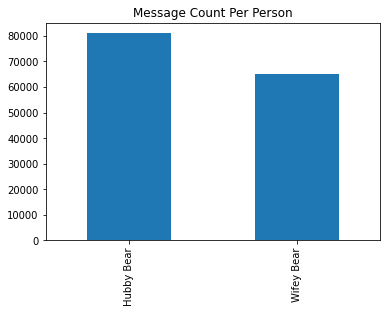

In [20]:
# See who texted each other more
clean_data['Sender'].value_counts().plot(kind='bar')
plt.title('Message Count Per Person')

In [21]:
# List to store day of week
days = []

# Extract and convert day of week to standard English
for day in clean_data['Date Message Sent'].dt.dayofweek:
  if day==0:
    d = 'Monday'
    days.append(d)
  elif day==1:
    d = 'Tuesday'
    days.append(d)
  elif day==2:
    d ='Wednesday'
    days.append(d)
  elif day==3:
    d ='Thursday'
    days.append(d)
  elif day==4:
    d = 'Friday'
    days.append(d)
  elif day==5:
    d ='Saturday'
    days.append(d)
  elif day==6:
    d ='Sunday'
    days.append(d)

# Add days as its own col 
clean_data['day'] = pd.Series(days)

(array([0, 1, 2, 3, 4, 5, 6]), <a list of 7 Text major ticklabel objects>)

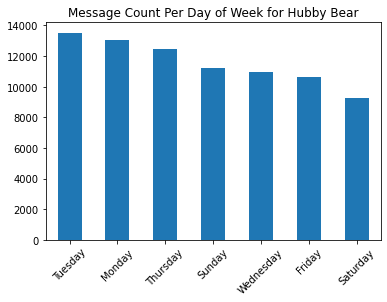

In [22]:
# See msg freq over days of week for Hubby Bear
clean_data[clean_data['Sender']=='Hubby Bear']['day'].value_counts().plot(kind='bar')
plt.title('Message Count Per Day of Week for Hubby Bear')
plt.xticks(rotation=45)

(array([0, 1, 2, 3, 4, 5, 6]), <a list of 7 Text major ticklabel objects>)

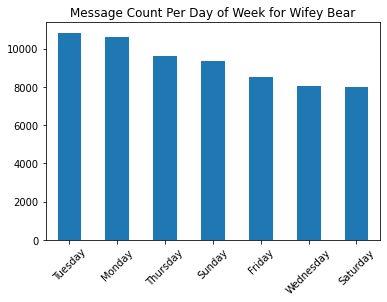

In [23]:
# See msg freq over days of week for Wifey Bear
clean_data[clean_data['Sender']=='Wifey Bear']['day'].value_counts().plot(kind='bar')
plt.title('Message Count Per Day of Week for Wifey Bear')
plt.xticks(rotation=45)

### WordClouds:

We will build word clouds to see what the most frequently used words are by each person.

However, we need to do further text cleaning:
- Remove use of proprietary stickers within the app (the characters are called "milk" and "merry")
- Look out for spelling errors and use of slang
- Weird symbols and punctuation

In [24]:
# prior to building wordcloud, clean and normalize text
clean_text = []

for msg in clean_data['Message']:
  # convert msg to lowercase
  text = msg.lower()

  # remove stickers used within app
  text = re.sub('(\(milk_)\w+\)', ' ', text) # milk character stickers
  text = re.sub('(\(merry_)\w+\)', ' ', text) # merry character stickers
  text = re.sub('sticker', ' ', text) # other stickers

  # remove images uploaded (denoted as image)
  text = re.sub('image', ' ', text)

  # remove punctuation
  text = re.sub('[^a-zA-Z]', ' ', text)

  # remove tags
  text = re.sub("&lt;/?.*?&gt;"," &lt;&gt; ", text)

  # remove digits and special chars
  text = re.sub("(\\d|\\W)+"," ", text)

  # append to clean list
  clean_text.append(text)

# Assign clean list to text column
clean_data['clean_text'] = clean_text

clean_data.head()

,Date Message Sent,Time Message Sent,Sender,Message,day,clean_text
0,2017-04-08,14:33:00,Wifey Bear,Hiiii boooo,Saturday,hiiii boooo
1,2017-04-08,14:33:00,Hubby Bear,First,Saturday,first
2,2017-04-08,14:39:00,Hubby Bear,(milk_face),Saturday,
3,2017-04-08,14:40:00,Hubby Bear,STICKER,Saturday,
4,2017-04-08,14:40:00,Hubby Bear,LOOOOOOL,Saturday,looooool


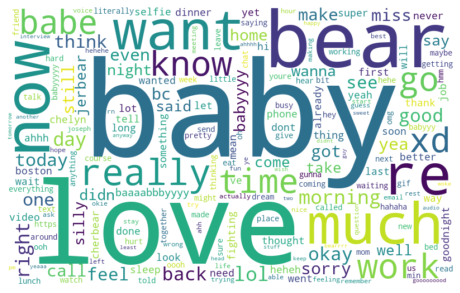

In [29]:
# Define stopwords
stopwords = set(STOPWORDS)

# add stop words that aren't in the NLTK stopwords list
new_stopwords = ['ll', 'going', 'im', 'don']
new_stopwords_list = stopwords.union(new_stopwords)

# Build overall word cloud excluding bigrams
overall_wc = WordCloud(width = 800, height = 500, collocations=False,
                       background_color = 'white', stopwords = new_stopwords_list, 
                       min_font_size = 10).generate(' '.join(clean_data['clean_text']))

# Plot word cloud
fig = plt.figure(figsize = (8,8), facecolor = None)
plt.imshow(overall_wc, interpolation="bilinear")
plt.axis('off')
plt.show()

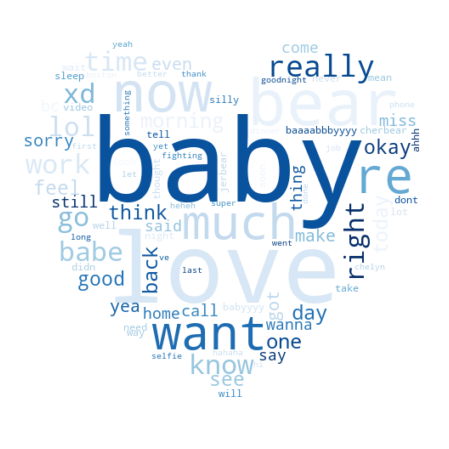

In [30]:
from PIL import Image
mask = np.array(Image.open('/content/drive/MyDrive/Colab Notebooks/NLP/heart.jpg'))

# Build word cloud for hubby bear
hubby_wc = WordCloud(width = 800, height = 800, collocations=False,
                     background_color = 'white', colormap="Blues",
                     stopwords = new_stopwords_list, mask=mask,
                     min_font_size = 10).generate(' '.join(clean_data[clean_data['Sender']=='Hubby Bear']['clean_text']))

# Plot word cloud
fig = plt.figure(figsize = (8,8), facecolor = None)
plt.imshow(hubby_wc, interpolation="bilinear")
plt.axis('off')
plt.show()

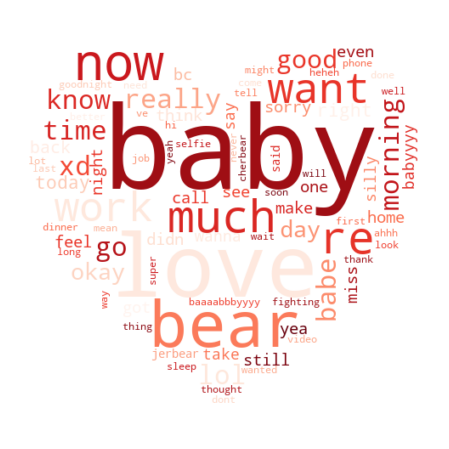

In [31]:
# Build word cloud for wifey bear
wifey_wc = WordCloud(width = 800, height = 800, collocations=False,
                     background_color = 'white', colormap='Reds',
                     stopwords = new_stopwords_list, mask=mask,
                     min_font_size=10).generate(' '.join(clean_data[clean_data['Sender']=='Wifey Bear']['clean_text']))

# Plot word cloud
fig = plt.figure(figsize = (8,8), facecolor = None)
plt.imshow(wifey_wc, interpolation="bilinear")
plt.axis('off')
plt.show()

### Get Vader Sentiments

VADER is a model that can detect both polarity (+/-) and intensity (strength) of emotion. It is intelligent enough to have basic contextual understanding and can distinguish emphasis due to capitalization and punctuation.


In [32]:
# Initialize model that converts str to a dict of scores in 4 categories
sentiment = SentimentIntensityAnalyzer()

# See sample polarity scores
sentiment.polarity_scores(data9['Message'][0])

# Add sentiment scores as its own column to df
clean_data['vader_sentiment'] = clean_data['Message'].apply(lambda x: sentiment.polarity_scores(x))
clean_data['vader_neg_sentiment'] = clean_data['vader_sentiment'].apply(lambda x: x['neg'])
clean_data['vader_pos_sentiment'] = clean_data['vader_sentiment'].apply(lambda x: x['pos'])
clean_data['vader_comp_sentiment'] = clean_data['vader_sentiment'].apply(lambda x: x['compound'])

# Preview df
clean_data.head()

,Date Message Sent,Time Message Sent,Sender,Message,day,clean_text,vader_sentiment,vader_neg_sentiment,vader_pos_sentiment,vader_comp_sentiment
0,2017-04-08,14:33:00,Wifey Bear,Hiiii boooo,Saturday,hiiii boooo,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0,0.0,0.0
1,2017-04-08,14:33:00,Hubby Bear,First,Saturday,first,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0,0.0,0.0
2,2017-04-08,14:39:00,Hubby Bear,(milk_face),Saturday,,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0,0.0,0.0
3,2017-04-08,14:40:00,Hubby Bear,STICKER,Saturday,,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0,0.0,0.0
4,2017-04-08,14:40:00,Hubby Bear,LOOOOOOL,Saturday,looooool,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0,0.0,0.0


In [33]:
# Most positive messages
clean_data.sort_values(by=['vader_comp_sentiment'], ascending=False)[['Message']].head()

,Message
84540,I love you I love you I love you I love you I ...
84542,I love you I love you I love you I love you I ...
84537,I love you I love you I love you I love you I ...
84538,I love you I love you I love you I love you I ...
84533,I love you I love you I love you I love you I ...


In [34]:
# Most negative messages
clean_data.sort_values(by=['vader_comp_sentiment'], ascending=True)[['Message']].head()

,Message
72939,"Since you prefer reading text, I’m here to lay..."
70333,I hear your words again in my head.. and they’...
125214,Joseph left for UNC and mom left for Korea - s...
122078,I wrote this BOMB ASS FREAKING BOSS LADY KILLE...
30679,Can you stop.. as soon as I started crying bc ...


### Get TextBlob Sentiments

TextBlob can calculate sentiment polarity ranging from -1 to 1 where 1 is positive and -1 is negative.

In [35]:
# Get textblob polarity scores on message and add scores as its own col
clean_data['textblob_polarity'] = clean_data['Message'].map(lambda x: TextBlob(x).sentiment.polarity)

# Add new column for message length
clean_data['msg_len'] = clean_data['Message'].astype(str).apply(len)

# Add new column for message word count
clean_data['word_count'] = clean_data['Message'].apply(lambda x: len(str(x).split()))

# Preview df
clean_data.head()

,Date Message Sent,Time Message Sent,Sender,Message,day,clean_text,vader_sentiment,vader_neg_sentiment,vader_pos_sentiment,vader_comp_sentiment,textblob_polarity,msg_len,word_count
0,2017-04-08,14:33:00,Wifey Bear,Hiiii boooo,Saturday,hiiii boooo,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0,0.0,0.0,0.00,11,2
1,2017-04-08,14:33:00,Hubby Bear,First,Saturday,first,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0,0.0,0.0,0.25,6,1
2,2017-04-08,14:39:00,Hubby Bear,(milk_face),Saturday,,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0,0.0,0.0,0.00,11,1
3,2017-04-08,14:40:00,Hubby Bear,STICKER,Saturday,,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0,0.0,0.0,0.00,7,1
4,2017-04-08,14:40:00,Hubby Bear,LOOOOOOL,Saturday,looooool,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0,0.0,0.0,0.00,8,1


In [36]:
# Most positive messages
clean_data.sort_values(by=['textblob_polarity'], ascending=False)[['Message', 'textblob_polarity']].head(10)

,Message,textblob_polarity
146085,you family = my family <3,1.0
7210,<3,1.0
36623,go to this site! <3,1.0
100915,I have internet now! :D,1.0
104807,<3 <3 <3,1.0
2264,Goodnight <3,1.0
85188,dont you worry <3,1.0
13813,I hope you have a wonderful day!,1.0
36571,I love you !!!!,1.0
13809,I hope you have a wonderful day babe,1.0


In [37]:
# Most negative messages
clean_data.sort_values(by=['textblob_polarity'], ascending=True)[['Message', 'textblob_polarity']].head(10)

,Message,textblob_polarity
16859,I have the worst luck ever....,-1.0
3594,i'm not works of evil,-1.0
97383,silly bear!!!!!,-1.0
65234,terrible hand skills?,-1.0
43078,SILLY BEARRRR!!!!,-1.0
131274,I don’t want to make impulse decisions either...,-1.0
120903,That's jerbear's worst nightmare...,-1.0
25084,And you assume I’m doing something terrible,-1.0
59043,That's literally the worst,-1.0
75563,silly bear !!!!,-1.0


In [38]:
# Most neutral

# save textblob neutral msgs
textblob_neutral = clean_data.query('textblob_polarity == 0').rename(columns={'Message': 'textblob_msg'})[['textblob_msg']].reset_index(drop=True)
print('Number of Neutral Msgs from TextBlob: ', textblob_neutral.shape[0])

# save vader neutral msgs
vader_neutral = clean_data.query('vader_comp_sentiment == 0').rename(columns={'Message': 'vader_msg'})[['vader_msg']].reset_index(drop=True)
print('Number of Neutral Msgs from Vader: ', vader_neutral.shape[0])

Number of Neutral Msgs from TextBlob:  90817
Number of Neutral Msgs from Vader:  84019


### More EDA

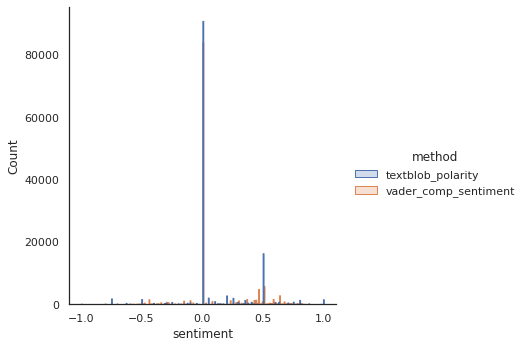

In [72]:
# Compare textblob and vader sentiment distribution

# Subset data to get important cols
subset = clean_data[['clean_text', 'textblob_polarity', 'vader_comp_sentiment', 'Date Message Sent', 'Sender', 'msg_len', 'word_count']]

# Melt df to get histogram
subset_long = subset.melt(id_vars=['clean_text', 'Date Message Sent', 'Sender', 'msg_len', 'word_count'], value_vars=['textblob_polarity', 'vader_comp_sentiment'], var_name='method', value_name='sentiment')

# Display histogram
sns.displot(subset_long, x="sentiment", hue="method", element="step")

Text(0.5, 1.0, 'Sentiment Scores Across Time')

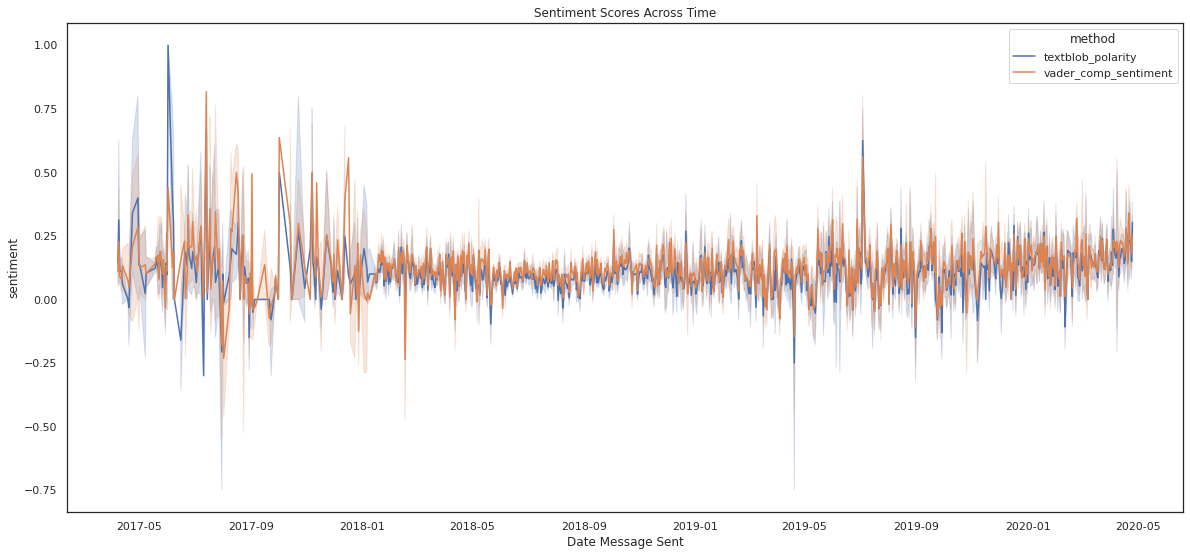

In [73]:
# Sentiments over time 
sns.set(rc={'figure.figsize':(20,9)})
sns.set_style(style='white')
sns.lineplot(x='Date Message Sent', y="sentiment", hue="method", data=subset_long)
plt.title('Sentiment Scores Across Time')

Text(0.5, 1.0, 'Daily Message Count Across Time')

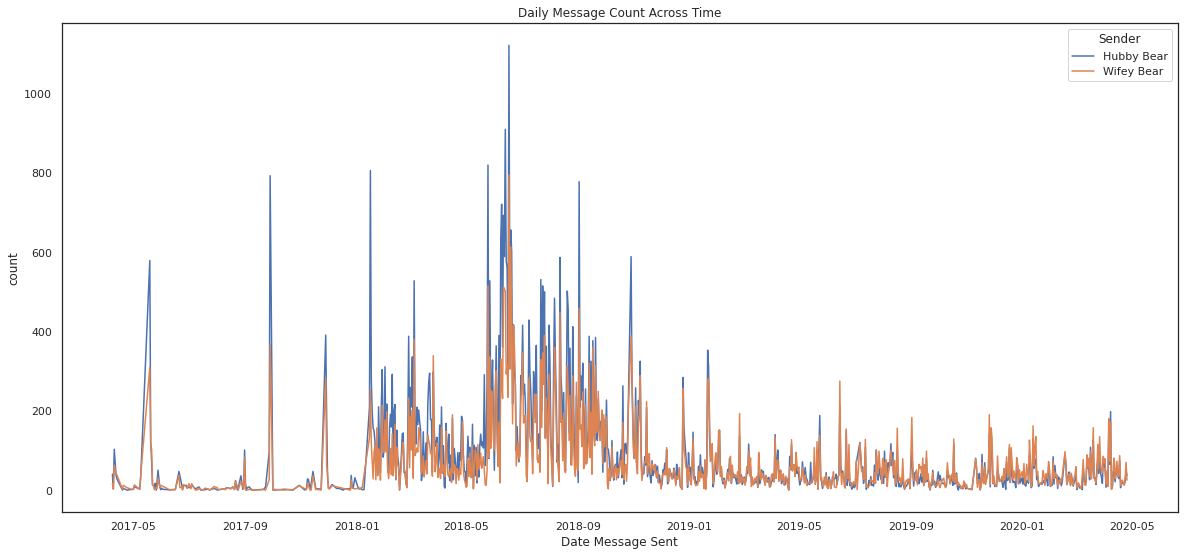

In [74]:
# Get daily message count per person
msg_count = clean_data.groupby(['Date Message Sent', 'day', 'Sender'])['Message'].size()
msg_count = msg_count.reset_index().rename(columns={'Message': 'count'})

# Plot message count across time
sns.set(rc={'figure.figsize':(20,9)})
sns.set_style(style='white')
sns.lineplot(x='Date Message Sent', y='count', hue='Sender', data=msg_count)
plt.title('Daily Message Count Across Time')

(array([0, 1, 2, 3, 4, 5, 6]), <a list of 7 Text major ticklabel objects>)

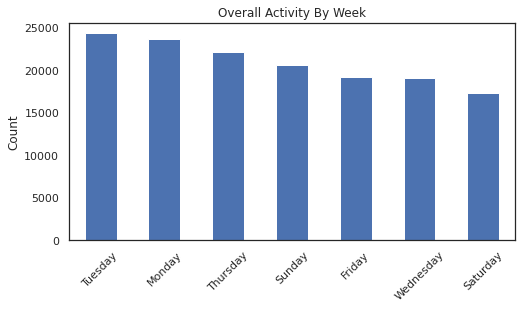

In [48]:
# Overall activity by week
plt.figure(figsize=(8,4))
clean_data['day'].value_counts().plot(kind='bar')
plt.title('Overall Activity By Week')
plt.ylabel('Count')
plt.xticks(rotation=45)

Text(0.5, 1.0, 'Message Activity By Week Per Person')

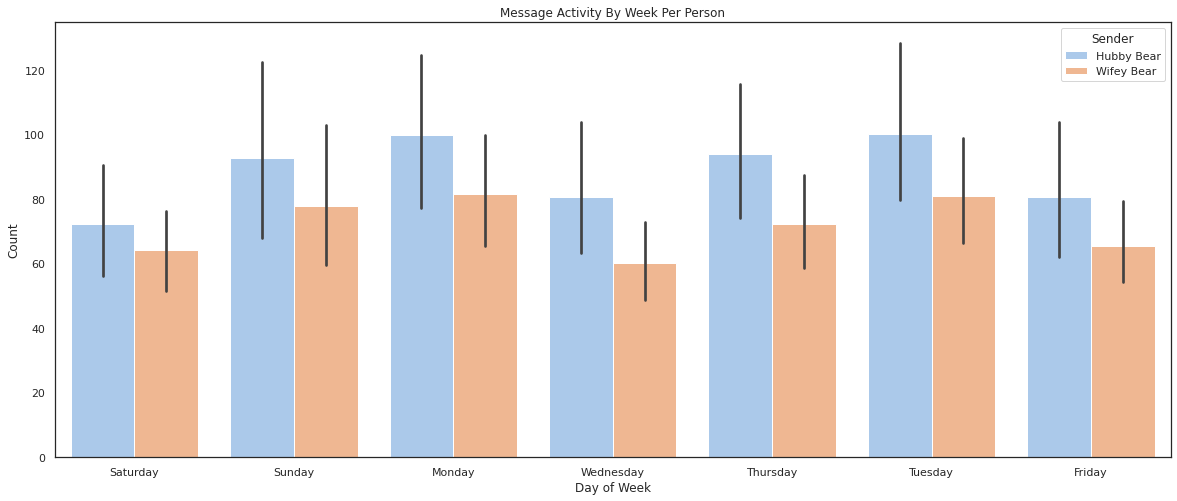

In [53]:
plt.figure(figsize=(20,8))
ax = sns.barplot(x="day", y="count", hue="Sender", data=msg_count, palette='pastel')
ax.set_xlabel('Day of Week')
ax.set_ylabel('Count')
ax.set_title('Message Activity By Week Per Person')

### Get most defining words for entire chat history

We will use the spaCy package to look for further text classification and derive meaningful patterns/themes.

***

First we get a "corpus" from spacy's pre-trained model and then we take our messages, transform it into a Scattertext Corpus, and find the words that are the most unlike this spacy corpus that represents the general english language (words that define the chat history).

In [54]:
# Load English tokenizer, tagger, parser, NER and word vectors 
nlp = spacy.load('en_core_web_lg')

In [80]:
only_textblob = subset_long.query('method == "textblob_polarity"')

# Get scattertext corpus (collection of documents with linguistic annotations)
corpus = st.CorpusFromPandas(only_textblob, text_col='clean_text', category_col='Sender', nlp=nlp).build()

# Terms that differentiate text from background text 
print(list(corpus.get_scaled_f_scores_vs_background().index[:20]))

['babyyyy', 'jerbear', 'baaaabbbyyyy', 'cherbear', 'selfie', 'chelyn', 'heheh', 'babyyyyy', 'babyyy', 'ahhh', 'gunna', 'gooooooood', 'yeaaa', 'bearrrr', 'goodnight', 'okie', 'ahhhh', 'idk', 'heheheh', 'oooh']


### K-Means Clustering

In [81]:
# text preprocessing
"""removes punctuation, stopwords, and returns a list of the remaining words, or tokens"""
import string
import emoji
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from nltk.tokenize import RegexpTokenizer
from nltk.stem.snowball import SnowballStemmer
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.stem import PorterStemmer, WordNetLemmatizer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [82]:
def text_process(text):
    # stemmer = WordNetLemmatizer()
    stemmer = PorterStemmer()
    nopunc = [char for char in text if char not in string.punctuation]
    nopunc = ''.join([i for i in nopunc if not i.isdigit()])
    nopunc =  [word.lower() for word in nopunc.split() if word not in stopwords.words('english')]
    # temp = [stemmer.lemmatize(word) for word in nopunc]
    temp = [stemmer.stem(word) for word in nopunc]

    joined = ' '.join(temp)

    # correct spelling 
    # joined = str(TextBlob(joined).correct())

    return joined.split()

In [109]:
# K-means
# Define corpus
corpus = clean_data['clean_text'].values

# Initialize vectorizer
vectorizer4 = TfidfVectorizer(analyzer = text_process, stop_words=new_stopwords_list, ngram_range=(1,3))

# Convert corpus to a matrix of TF-IDF features
X4 = vectorizer4.fit_transform(corpus)
words = vectorizer4.get_feature_names()

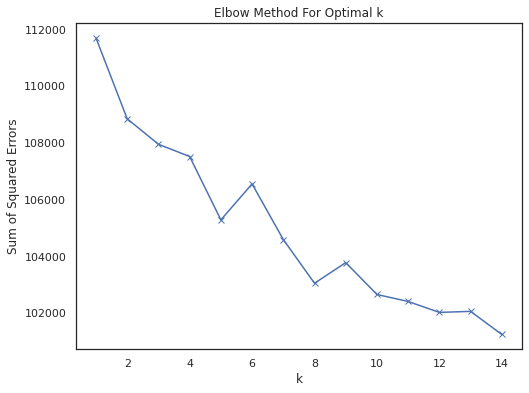

5

In [110]:
"""Initialize k-means for 1-15 clusters and use the inertia attribute to identify 
the sum of squared error of samples to the nearest cluster centre"""

# list holds the SSE values for each k
sse = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k) # initialize k-means
    km = km.fit(X4) # compute k-means clustering
    sse.append(km.inertia_) # append SSE of samples to their closest cluster center
    

"""As k increases, the sum of squared error approaches zero. 
If we set k to its maximum value n (where n is number of samples) each 
obs will form its own cluster meaning sum of squared error equals zero.
"""

# Plot of sum of squared errors for k in the range specified above. The elbow shows the optimal k.
plt.figure(figsize=(8,6))
plt.plot(K, sse, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum of Squared Errors')
plt.title('Elbow Method For Optimal k')
plt.show()

# identify the elbow point programmatically with kneed package
!pip install kneed
from kneed import KneeLocator

kl = KneeLocator(range(1, 15), sse, curve="convex", direction="decreasing")
kl.elbow # suggests 5 clusters

In [112]:
kmeans = KMeans(n_clusters = 5, n_init = 20, n_jobs = 1) # n_init(number of iterations for clustering) n_jobs(number of cpu cores to use)
kmeans.fit(X4)

# We look at 5 the clusters generated by k-means.
common_words = kmeans.cluster_centers_.argsort()[:,-1:-26:-1]
for num, centroid in enumerate(common_words):
    print(str(num) + ' : ' + ', '.join(words[word] for word in centroid))

0 : cherbear, jerbear, energi, love, want, wait, much, need, bear, see, give, go, worri, miss, babi, forget, kiss, eat, realli, never, think, wanna, day, make, work
1 : love, much, babi, bear, chelyn, jeremi, jerbear, letter, silli, heheh, babe, make, okay, soooooo, sooooooo, goodnight, hehe, soooo, mochi, say, still, tell, sooooo, thank, want
2 : get, rest, back, babi, home, readi, go, lot, work, job, call, soon, want, realli, start, paid, sleep, know, tri, im, skype, thought, worri, let, text
3 : bear, go, like, xd, babe, want, call, lol, work, yea, realli, miss, know, baaaabbbyyyy, babyyyy, im, right, think, okay, time, wait, morn, day, see, good
4 : babi, okay, morn, goodnight, sorri, good, fight, thank, miss, work, hey, home, go, gooooooood, heheh, fun, yea, bear, much, safe, done, im, call, cours, day
